In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import os

# Paths
MODEL_PATH = r"ENTER MODEL PATH"
VIDEO_PATH = r"ENTER VIDEO PATH"


In [ ]:
cnn_model = load_model(MODEL_PATH)
print("CNN model loaded.")

yolo_model = YOLO("yolov8n.pt")
print("YOLOv8 model loaded.")


✅ CNN model loaded.
✅ YOLOv8 model loaded.


In [ ]:
import pywhatkit

def send_emergency_alert(phone_number="+917981832110"):

    try:
        message = "ALERT! A vehicle crash has been detected. Please check immediately!"
        pywhatkit.sendwhatmsg_instantly(phone_number, message)
        print(f"Emergency alert sent to {phone_number} via WhatsApp!")
    except Exception as e:
        print(f"Failed to send WhatsApp alert: {e}")


In [32]:
def preprocess_crop(crop):
    crop_resized = cv2.resize(crop, (128, 128)) / 255.0
    crop_input = np.expand_dims(crop_resized, axis=0)
    return crop_input

In [ ]:
import requests
import json
def send_to_cloud(vehicle_id, confidence, frame_no):
    url = "http://127.0.0.1:5001/demo-no-project/us-central1/accidentEvent" 
    data = {
        "vehicle_id": str(vehicle_id), 
        "crash_confidence": float(confidence), 
        "frame_number": int(frame_no) 
    } 
    try:
        res = requests.post(url, data=json.dumps(data), headers={"Content-Type": "application/json"})
        print("Sent crash event to cloud:", res.text)
    except Exception as e:
        print("Failed to send event to cloud:", e)

In [ ]:
import base64
import requests

def upload_crash_image(image, vehicle_id):
    try:
        ok, buffer = cv2.imencode(".jpg", image)
        if not ok:
            print("Failed to encode image")
            return
        
        url = (
            "http://127.0.0.1:9199/v0/b/demo-no-project.appspot.com/o"
            f"?uploadType=media&name=crash_images/{vehicle_id}.jpg"
        )

        headers = {
            "Content-Type": "image/jpeg"
        }

        res = requests.post(url, data=buffer.tobytes(), headers=headers)

        print(f"Uploaded crash image → {vehicle_id}.jpg")
        print("Emulator Response:", res.text)

    except Exception as e:
        print("Image upload failed:", e)



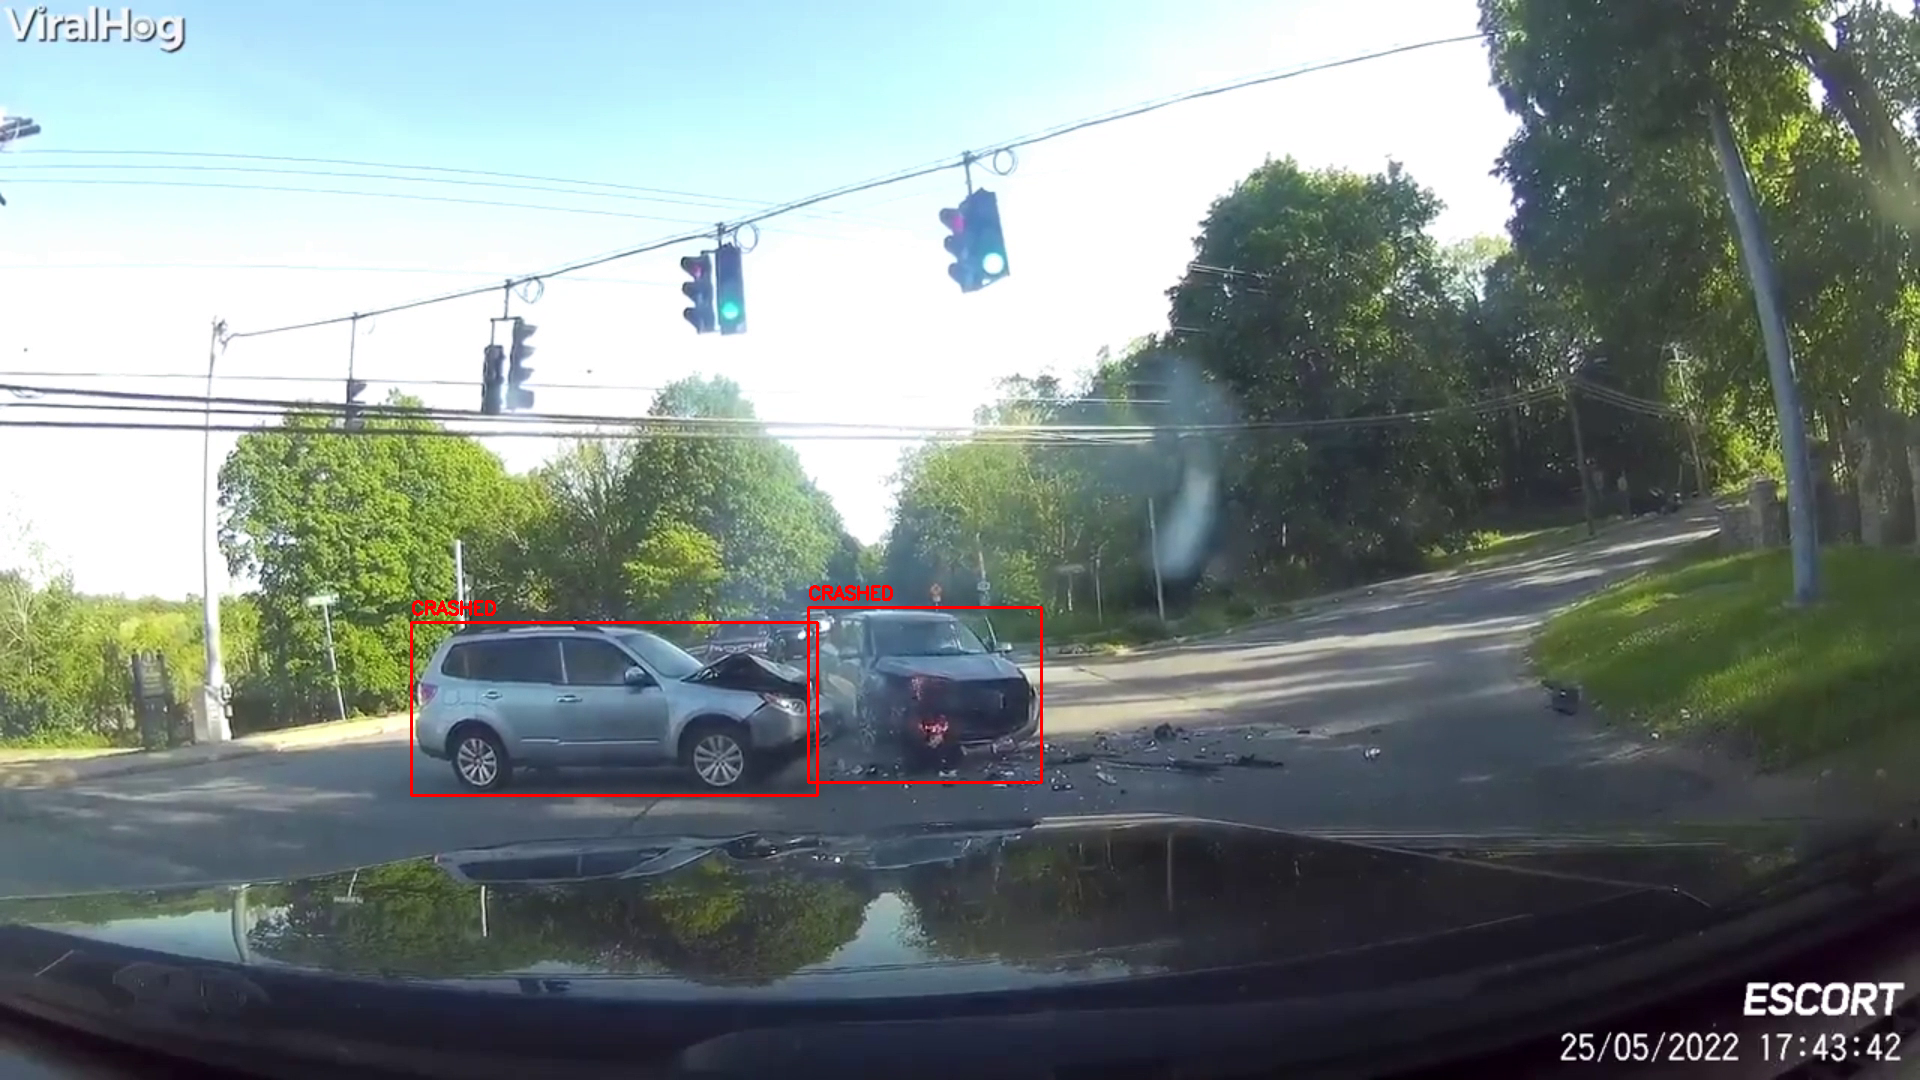

🎬 Video playback complete.


In [ ]:
from collections import deque
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from IPython.display import display, clear_output
from PIL import Image

yolo_model = YOLO("yolov8n.pt")
cnn_model = load_model(MODEL_PATH)

vehicle_crash_score = {}
vehicle_crashed = {}
vehicle_frame_count = {}
vehicle_prev_pos = {}
vehicle_trackers = {}
crashed_positions = {}
crashed_crops = {}
vehicle_was_moving = {}
crash_persistence = {}

CRASH_CONF_THRESHOLD = 0.9
FRAME_CONFIRMATION_THRESHOLD = 25
CRASH_PERSISTENCE_FRAMES = 6
MIN_FRAMES_BEFORE_CRASH = 5
MOVEMENT_THRESHOLD = 5
OCCLUSION_DISTANCE_THRESHOLD = 50
MOVING_AWAY_THRESHOLD = 3

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Video playback complete.")
        break

    frame_count += 1
    results = yolo_model.track(frame, persist=True, verbose=False)[0]

    for box in results.boxes:
        cls = int(box.cls[0])
        if results.names[cls] != "car":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        if conf < 0.4:
            continue

        obj_id = int(box.id[0]) if box.id is not None else f"{x1}-{y1}-{x2}-{y2}"
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        crop_resized = cv2.resize(crop, (128, 128)) / 255.0
        crop_input = np.expand_dims(crop_resized, axis=0)
        pred_vec = cnn_model.predict(crop_input, verbose=0)[0]
        raw_pred = pred_vec[1]

        if obj_id not in vehicle_crash_score:
            vehicle_crash_score[obj_id] = 0
            vehicle_crashed[obj_id] = False
            vehicle_frame_count[obj_id] = 0
            vehicle_prev_pos[obj_id] = (0,0)
            vehicle_trackers[obj_id] = deque(maxlen=8)
            vehicle_was_moving[obj_id] = False
            crash_persistence[obj_id] = 0

        if vehicle_crashed[obj_id]:
            color = (0, 0, 255)
            label = "CRASHED"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        vehicle_frame_count[obj_id] += 1

        if vehicle_frame_count[obj_id] < MIN_FRAMES_BEFORE_CRASH:
            color = (255, 255, 0)
            label = "INITIALIZING"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        prev_cx, prev_cy = vehicle_prev_pos[obj_id]
        dx = cx - prev_cx
        dy = cy - prev_cy
        movement = np.hypot(dx, dy)
        vehicle_prev_pos[obj_id] = (cx, cy)

        if movement >= MOVEMENT_THRESHOLD:
            vehicle_was_moving[obj_id] = True

        overlaps_crashed = False
        for crashed_id, pos in crashed_positions.items():
            dist = np.hypot(pos[0] - cx, pos[1] - cy)
            if dist < OCCLUSION_DISTANCE_THRESHOLD:
                overlaps_crashed = True
                break

        if movement < MOVEMENT_THRESHOLD:
            if not vehicle_was_moving[obj_id] and not overlaps_crashed:
                color = (0, 255, 255)
                label = f"STATIONARY ({vehicle_crash_score[obj_id]})"
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 8),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                continue

        if dx > MOVING_AWAY_THRESHOLD:
            color = (0, 255, 255)
            label = "MOVING AWAY"
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            continue

        vehicle_trackers[obj_id].append(raw_pred)
        smoothed_pred = np.mean(vehicle_trackers[obj_id])

        if smoothed_pred > CRASH_CONF_THRESHOLD:
            vehicle_crash_score[obj_id] += 1
        else:
            vehicle_crash_score[obj_id] = max(0, vehicle_crash_score[obj_id] - 1)

        if vehicle_crash_score[obj_id] >= FRAME_CONFIRMATION_THRESHOLD:
            crash_persistence[obj_id] += 1
            if crash_persistence[obj_id] == CRASH_PERSISTENCE_FRAMES and obj_id not in crashed_crops:
                vehicle_crashed[obj_id] = True
                crashed_positions[obj_id] = (cx, cy)
                crashed_crops[obj_id] = crop.copy()

            color = (0, 0, 255)
            label = f"CRASH CONFIRMED ({vehicle_crash_score[obj_id]})"
        else:
            crash_persistence[obj_id] = 0
            color = (255, 0, 0)
            label = f"SAFE ({vehicle_crash_score[obj_id]})"

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    display(Image.fromarray(rgb_frame))

cap.release()


In [ ]:
import requests, json

url = "http://127.0.0.1:5001/demo-no-project/us-central1/accidentEvent"

for obj_id in crashed_crops.keys():
    data = {
        "vehicle_id": str(obj_id),
        "crash_confidence": 1.0,
        "frame_number": 9999
    }

    try:
        res = requests.post(url, data=json.dumps(data), headers={"Content-Type": "application/json"})
        print(f"Sent crash event for vehicle {obj_id}. Response:", res.text)
    except Exception as e:
        print(f"Failed to send cloud event for {obj_id}:", e)


✅ Sent crash event for vehicle 6. Response: {"ok":true,"msg":"Event stored in Firestore","data":{"vehicle_id":"6","crash_confidence":1,"frame_number":9999,"received_at":{"_seconds":1762828986,"_nanoseconds":994000000}}}
✅ Sent crash event for vehicle 8. Response: {"ok":true,"msg":"Event stored in Firestore","data":{"vehicle_id":"8","crash_confidence":1,"frame_number":9999,"received_at":{"_seconds":1762828989,"_nanoseconds":738000000}}}


Crashed car images (one per car):


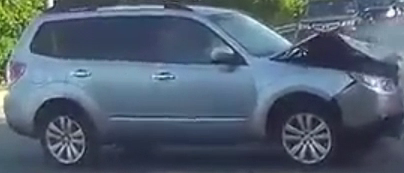

✅ Uploaded crash image → 6.jpg
📥 Emulator Response: {"name":"crash_images/6.jpg","bucket":"demo-no-project.appspot.com","generation":"1762829000744","metageneration":"1","contentType":"application/octet-stream","timeCreated":"2025-11-11T02:43:20.745Z","updated":"2025-11-11T02:43:20.745Z","storageClass":"STANDARD","size":"22177","md5Hash":"0uJMK/IXRdm82RJqLBRc6A==","crc32c":"2508952924","etag":"ZEl5cpdJdfAwiF3DbdxWAVP+AYQ","downloadTokens":"d88b1967-3d65-4b83-9571-5206bc145dce","contentEncoding":"identity","contentDisposition":"inline","metadata":{}}
✅ Uploaded crash image for vehicle 6


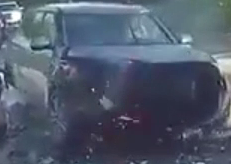

✅ Uploaded crash image → 8.jpg
📥 Emulator Response: {"name":"crash_images/8.jpg","bucket":"demo-no-project.appspot.com","generation":"1762829001151","metageneration":"1","contentType":"application/octet-stream","timeCreated":"2025-11-11T02:43:21.151Z","updated":"2025-11-11T02:43:21.151Z","storageClass":"STANDARD","size":"12018","md5Hash":"ySaLV19/oSjb4NFAWm5jAA==","crc32c":"3550044754","etag":"pRQHPSvtCwikZYTWSIP1B8di62Y","downloadTokens":"5d5749e4-d7d7-4e54-8060-7aada468c7e8","contentEncoding":"identity","contentDisposition":"inline","metadata":{}}
✅ Uploaded crash image for vehicle 8


In [ ]:
print("Crashed car images (one per car):")
for obj_id, crop_img in crashed_crops.items():
    
    display(Image.fromarray(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)))

    upload_crash_image(crop_img, obj_id)

    print(f"Uploaded crash image for vehicle {obj_id}")


In [ ]:
import os
from twilio.rest import Client

ACCOUNT_SID = "XXXXXXXX"
AUTH_TOKEN = "XXXXXX"
TWILIO_NUMBER = "XXXXXXXXXX"
EMERGENCY_NUMBER = "XXXXXXXX"

client = Client(ACCOUNT_SID, AUTH_TOKEN)

def send_sms(crash_count=None):
    if crash_count is None:
        crash_count = len(crashed_crops)

    if crash_count == 0:
        print("No crashes → No SMS sent.")
        return

    elif crash_count == 1:
        message = "Crash detected! One vehicle involved. Please check immediately."
    else:
        message = f"Crash detected! {crash_count} vehicles involved. Please check immediately!"

    try:
        sms = client.messages.create(
            body=message,
            from_=TWILIO_NUMBER,
            to=EMERGENCY_NUMBER
        )
        print("SMS sent! SID:", sms.sid)

    except Exception as e:
        print("SMS failed:", e)



def call_emergency_contact(crash_count=None):
    if crash_count is None:
        crash_count = len(crashed_crops)

    if crash_count == 0:
        print("No crashes → No call made.")
        return

    elif crash_count == 1:
        message = "There has been a confirmed crash involving one vehicle. Please reach the scene immediately."
    else:
        message = f"There has been a confirmed crash involving {crash_count} vehicles. Please reach the scene immediately."

    try:
        print(f"Calling {EMERGENCY_NUMBER} with message: {message}")

        twiml_message = f"<Response><Say voice='alice'>{message}</Say></Response>"

        call = client.calls.create(
            to=EMERGENCY_NUMBER,
            from_=TWILIO_NUMBER,
            twiml=twiml_message
        )

        print("Voice call placed! Call SID:", call.sid)

    except Exception as e:
        print("Call failed:", e)


In [54]:
send_sms()
call_emergency_contact()

✅ SMS sent! SID: SMe89a2991ab0c7d5bd49d62c478d57545
📞 Calling +917981832110 with message: There has been a confirmed crash involving 2 vehicles. Please reach the scene immediately.
✅ Voice call placed! Call SID: CA97492213e37c7472c5be6257750d2a20
